In [4]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import Lambda

Load FashionMNIST dataset

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
train_dataloader = DataLoader(training_data, batch_size=64)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
test_dataloader = DataLoader(test_data, batch_size=64)

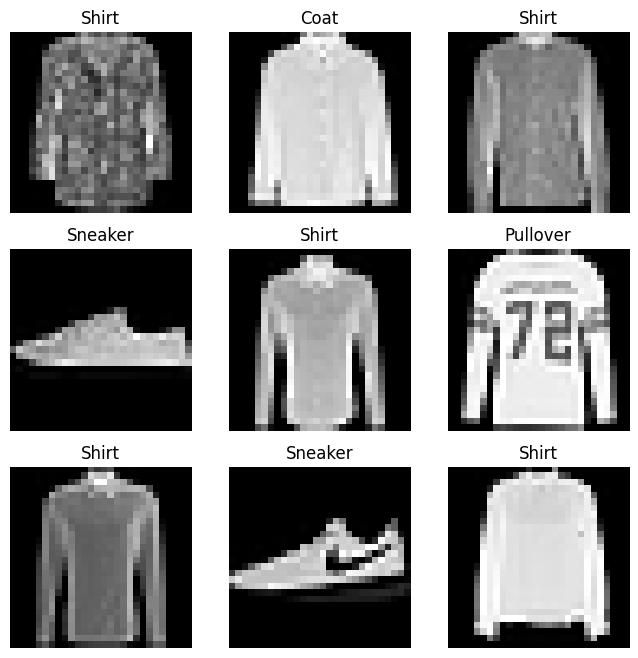

In [3]:
import matplotlib.pyplot as plt
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Transforms

In [5]:
ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

Build the Neural Network

In [6]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [7]:
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Create a training loop

In [8]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [9]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [10]:
train_losses = []
test_losses = []

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0  # Tổng loss trong epoch

    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()  # Cộng dồn loss để tính trung bình

        if batch % 100 == 0:
            loss_val, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss = total_loss / len(dataloader)
    train_losses.append(avg_loss)
    print(f"Average training loss: {avg_loss:.6f}")

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    test_losses.append(test_loss)
    print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")

Evaluate model accuracy

In [11]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.304754  [   64/60000]
loss: 2.291966  [ 6464/60000]
loss: 2.271201  [12864/60000]
loss: 2.265144  [19264/60000]
loss: 2.256528  [25664/60000]
loss: 2.225635  [32064/60000]
loss: 2.236539  [38464/60000]
loss: 2.203733  [44864/60000]
loss: 2.206534  [51264/60000]
loss: 2.175415  [57664/60000]
Average training loss: 2.239536
Test Error: Accuracy: 45.8%, Avg loss: 2.169639

Epoch 2
-------------------------------
loss: 2.182914  [   64/60000]
loss: 2.169363  [ 6464/60000]
loss: 2.116281  [12864/60000]
loss: 2.129544  [19264/60000]
loss: 2.080019  [25664/60000]
loss: 2.030818  [32064/60000]
loss: 2.055804  [38464/60000]
loss: 1.983823  [44864/60000]
loss: 1.995169  [51264/60000]
loss: 1.916553  [57664/60000]
Average training loss: 2.056632
Test Error: Accuracy: 51.7%, Avg loss: 1.915082

Epoch 3
-------------------------------
loss: 1.949112  [   64/60000]
loss: 1.916575  [ 6464/60000]
loss: 1.805216  [12864/60000]
loss: 1.844883  [19264/60000

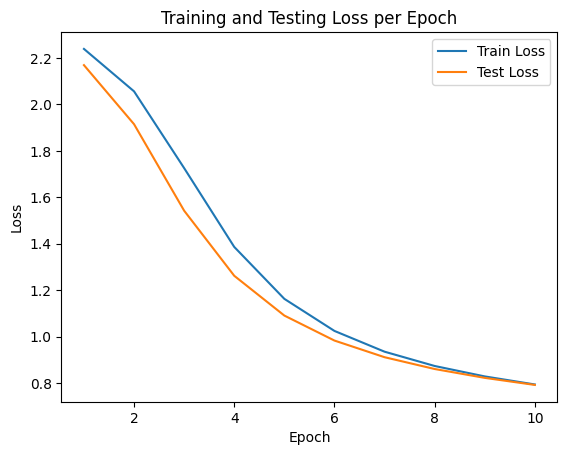

In [12]:
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss per Epoch')
plt.legend()
plt.show()

Save and Load the Model

In [13]:
import torch
import torch.nn as nn

# Lưu mô hình sau khi huấn luyện
MODEL_PATH = "fashion_mnist_model.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f"Đã lưu mô hình tại: {MODEL_PATH}")

# Tải lại mô hình (phải định nghĩa lại kiến trúc giống ban đầu)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Khởi tạo mô hình mới
loaded_model = NeuralNetwork()
# Nạp lại trọng số đã lưu
loaded_model.load_state_dict(torch.load(MODEL_PATH))
loaded_model.eval()
print(" Đã tải lại mô hình và sẵn sàng dự đoán.")

# Kiểm tra thử mô hình đã tải lại
test_sample, test_label = test_data[0]
with torch.no_grad():
    pred = loaded_model(test_sample)
    predicted, actual = pred[0].argmax(0), test_label
    print(f"Dự đoán: {predicted}, Thực tế: {actual}")


Đã lưu mô hình tại: fashion_mnist_model.pth
 Đã tải lại mô hình và sẵn sàng dự đoán.
Dự đoán: 9, Thực tế: 9


In [14]:
class DeepNeuralNetwork(nn.Module):
    def __init__(self):
        super(DeepNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.2),          # thêm dropout để tránh overfitting
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = DeepNeuralNetwork()
learning_rate = 0.01   # tăng learning rate
batch_size = 128       # thay đổi batch size
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()


Epoch 1
-------------------------------
Test Error: Accuracy: 82.35%, Avg loss: 0.515355
Epoch 2
-------------------------------
Test Error: Accuracy: 80.60%, Avg loss: 0.508849
Epoch 3
-------------------------------
Test Error: Accuracy: 83.74%, Avg loss: 0.463295
Epoch 4
-------------------------------
Test Error: Accuracy: 83.06%, Avg loss: 0.470428
Epoch 5
-------------------------------
Test Error: Accuracy: 83.94%, Avg loss: 0.452310
Epoch 6
-------------------------------
Test Error: Accuracy: 83.99%, Avg loss: 0.463684
Epoch 7
-------------------------------
Test Error: Accuracy: 84.01%, Avg loss: 0.455209
Epoch 8
-------------------------------
Test Error: Accuracy: 84.25%, Avg loss: 0.444129
Epoch 9
-------------------------------
Test Error: Accuracy: 83.66%, Avg loss: 0.453431
Epoch 10
-------------------------------
Test Error: Accuracy: 84.71%, Avg loss: 0.443028
Huấn luyện hoàn tất!


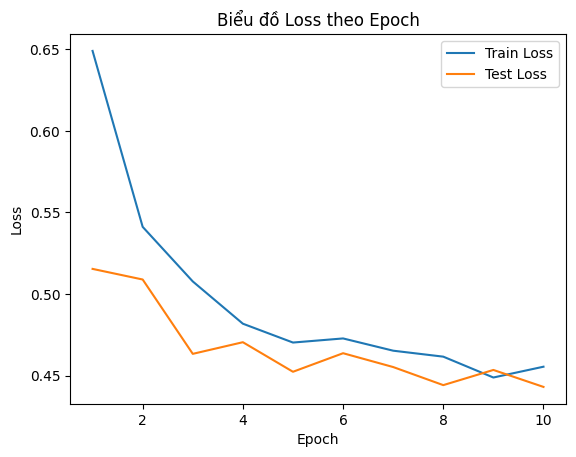

In [15]:
import matplotlib.pyplot as plt

train_losses = []
test_losses = []

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    total_loss = 0

    # Huấn luyện
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Đánh giá
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= len(test_dataloader)
    test_losses.append(test_loss)
    acc = correct / len(test_dataloader.dataset)
    print(f"Test Error: Accuracy: {100*acc:.2f}%, Avg loss: {test_loss:.6f}")

print("Huấn luyện hoàn tất!")

# Vẽ biểu đồ Loss
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Biểu đồ Loss theo Epoch")
plt.legend()
plt.show()


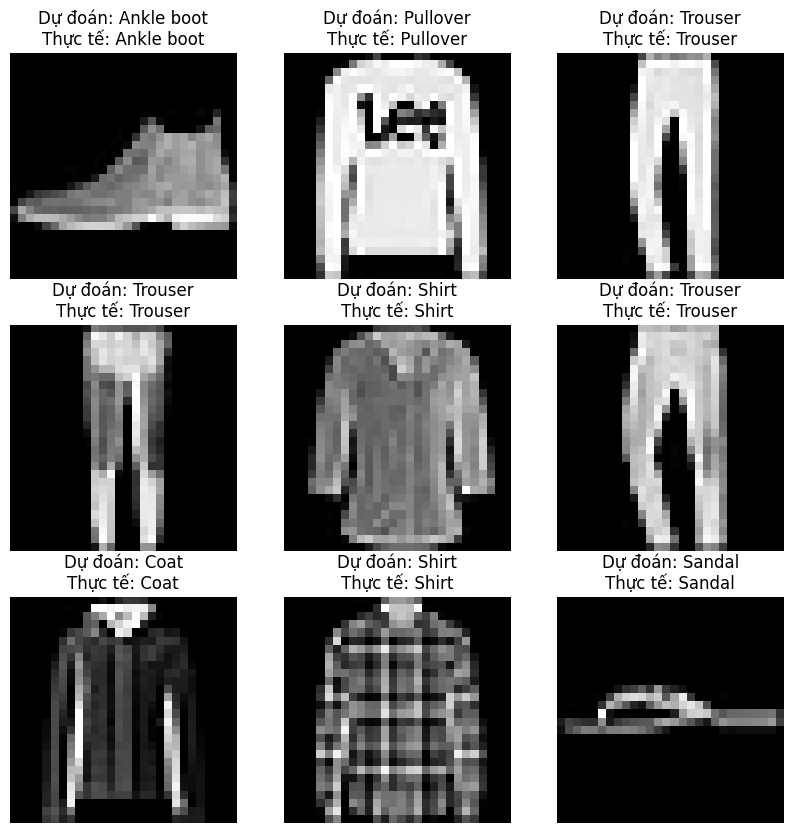

In [16]:
import matplotlib.pyplot as plt

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

model.eval()
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    img, label = test_data[i]
    with torch.no_grad():
        pred = model(img)
        predicted = classes[pred[0].argmax(0)]
        actual = classes[label]
    plt.subplot(3, 3, i+1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"Dự đoán: {predicted}\nThực tế: {actual}")
    plt.axis("off")

plt.show()
